# Support for spatial transcriptomics

For more information on the support for spatial transcriptomics, please see the [SPArrOW documentation](https://sparrow-pipeline.readthedocs.io/en/latest). Harpy focusses on the analysis of spatial proteomics data and extends the SPArrOW pipeline to support highly-multiplexed images.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# To run this notebook with CUDA, install dask-cuda:
#    uv pip install dask-cuda==24.12.0
#
# We pin to this version because spatialdata requires
# dask>=2024.10.0,<=2024.11.2, and dask-cuda 24.12.0
# is the latest release compatible with that range.

import harpy

## 1. Read in the data

The first step includes reading in the raw data.

The example dataset for this notebook will be downloaded and cached using `pooch` via `harpy.dataset.registry`.


### Convert to zarr and read the image


In [3]:
import os
import tempfile
import uuid

from harpy.datasets.registry import get_registry

# change this path. It is the directory where the spatialdata .zarr will be saved.
OUTPUT_DIR = tempfile.gettempdir()

img_layer = "raw_image"

path = None  # If None, example data will be downloaded in the default cache folder of your os. Set this to a custom path, to change this behaviour.
registry = get_registry(path=path)
path_image = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_DAPI.tiff")

# you can choose any name for your zarr file
zarr_path = os.path.join(OUTPUT_DIR, f"sdata_{uuid.uuid4()}.zarr")

sdata = harpy.io.create_sdata(
    input=path_image,
    output_path=zarr_path,
    img_layer=img_layer,
    chunks=1024,
)

/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


INFO     The Zarr backing store has been changed from None the new file path:                                      
         /var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_248e8a9c-de95-4710-a29c-3a43534a7045.zarr          


/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
2025-09-25 10:47:57,817 - harpy.image._manager - INFO - Writing results to layer 'raw_image'
version mismatch: detected: RasterFormatV02, requested: FormatV04


## 2. Plot the image


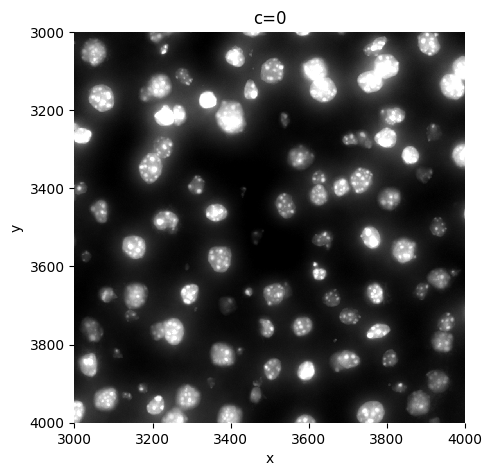

In [4]:
harpy.pl.plot_image(
    sdata,
    img_layer="raw_image",
    crd=[3000, 4000, 3000, 4000],  # region to plot [x_min, xmax, y_min, y_max]
    figsize=(5, 5),
)

## 3. Segment using Cellpose


In [5]:
import torch
from dask.distributed import Client, LocalCluster

from harpy.image import cellpose_callable

if torch.cuda.is_available():
    from dask_cuda import LocalCUDACluster  # pip install dask-cuda

    # One worker per GPU; each worker will be pinned to a single GPU.
    cluster = LocalCUDACluster(
        CUDA_VISIBLE_DEVICES=[0],  # or [0,1],...etc
        n_workers=1,  # 2 if [0,1],...etc
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),#
    )
else:
    # cpu/mps fall back
    from dask.distributed import LocalCluster

    cluster = LocalCluster(
        n_workers=1
        if torch.backends.mps.is_available()
        else 8,  # If mps/cuda device available, it is better to increase chunk size to maximal value that fits on the gpu, and set n_workers to 1.
        # For this dummy example, we only have one chunk, so setting n_workers>1, has no effect.
        threads_per_worker=1,
        memory_limit="32GB",
        # local_directory=os.environ.get( "TMPDIR" ),
    )

client = Client(cluster)

print(client.dashboard_link)

sdata = harpy.im.segment(
    sdata,
    img_layer="raw_image",
    depth=200,
    model=cellpose_callable,
    # parameters that will be passed to the callable cellpose_callable
    diameter=50,
    flow_threshold=0.9,
    cellprob_threshold=-4,
    output_labels_layer="segmentation_mask",
    output_shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],  # region to segment [x_min, xmax, y_min, y_max],
    overwrite=True,
)
client.close()



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.11.0 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




objc[90225]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x380e69698) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x38afc12f8). One of the two will be used. Which one is undefined.
objc[90225]: Class KeyValueObserver is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x380e696c0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x38afc1320). One of the two will be used. Which one is undefined.
objc[90225]: Class RunLoopModeTracker is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x380e695d0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x38afc1370). One of the two will be used. Which one is undefined.
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/dis

http://127.0.0.1:50439/status


/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.11.0 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




objc[90326]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x30e7b9698) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x340a292f8). One of the two will be used. Which one is undefined.
objc[90326]: Class KeyValueObserver is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x30e7b96c0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x340a29320). One of the two will be used. Which one is undefined.
objc[90326]: Class RunLoopModeTracker is implemented in both /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt6Core.6.9.2.dylib (0x30e7b95d0) and /Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/libQt5Core.5.15.15.dylib (0x340a29370). One of the two will be used. Which one is undefined.
pretrained model /Users/arnedf/.cellpose/models/cpsam not found, using defa

## 4. Visualize resulting segmentation

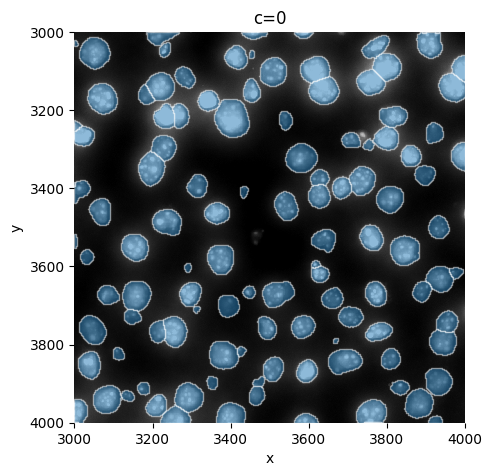

In [6]:
harpy.pl.plot_shapes(
    sdata,
    img_layer="raw_image",
    shapes_layer="segmentation_mask_boundaries",
    crd=[3000, 4000, 3000, 4000],
    figsize=(5, 5),
)

## 5. Create AnnData table

In [7]:
# read in the points
path_transcripts = registry.fetch("transcriptomics/resolve/mouse/20272_slide1_A1-1_results.txt")
sdata = harpy.io.read_resolve_transcripts(sdata, path_count_matrix=path_transcripts, output_layer="transcripts")
sdata

2025-09-25 10:48:13,756 - harpy.io._transcripts - INFO - No transform matrix given, will use identity matrix.
2025-09-25 10:48:13,756 - harpy.io._transcripts - INFO - Transform matrix used:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


SpatialData object, with associated Zarr store: /private/var/folders/q5/7yhs0l6d0x771g7qdbhvkvmr0000gp/T/sdata_248e8a9c-de95-4710-a29c-3a43534a7045.zarr
├── Images
│     └── 'raw_image': DataArray[cyx] (1, 12864, 10720)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (1000, 1000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
└── Shapes
      └── 'segmentation_mask_boundaries': GeoDataFrame shape: (116, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), segmentation_mask_boundaries (Shapes)

In [8]:
sdata = harpy.tb.allocate(
    sdata,
    labels_layer="segmentation_mask",
    points_layer="transcripts",
    output_layer="table_transcriptomics",
    overwrite=True,
)
sdata["table_transcriptomics"]

2025-09-25 10:48:17,568 - harpy.table._allocation - INFO - Calculating cell counts.
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/arnedf/miniconda3/envs/harpy_1_9_25/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:184: UserWarning: The table is annotating 'segmentation_mask', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
2025-09-25 10:48:17,987 - harpy.shape._manager - INFO - Filtering 1 cells from shapes layer 'segmentation_mask_boundaries'. Adding new shapes layer 'filtered_segmentation_segmentation_mask_boundaries' containing these filtered out polygons.
2025-09-25 10:48:18,047 - harpy.utils._io - WARNING - layer with name 'segmentation_mask_boundaries' already exists. Overwriting...


AnnData object with n_obs × n_vars = 115 × 71
    obs: 'cell_ID', 'fov_labels'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [19]:
sdata["table_transcriptomics"].to_df().head()

,Adamtsl2,Adgre1,Atp6v0d2,Axl,C5ar1,Ccr2,Cd207,Cd209a,Cd36,Cd3e,...,Sox9,Spn,Spon2,Stab2,Timd4,Tmem119,Vsig4,Vwf,Wnt2,Wnt9b
cells,,,,,,,,,,,,,,,,,,,,,
28_segmentation_mask_aa7cb467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32_segmentation_mask_aa7cb467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34_segmentation_mask_aa7cb467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35_segmentation_mask_aa7cb467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
36_segmentation_mask_aa7cb467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


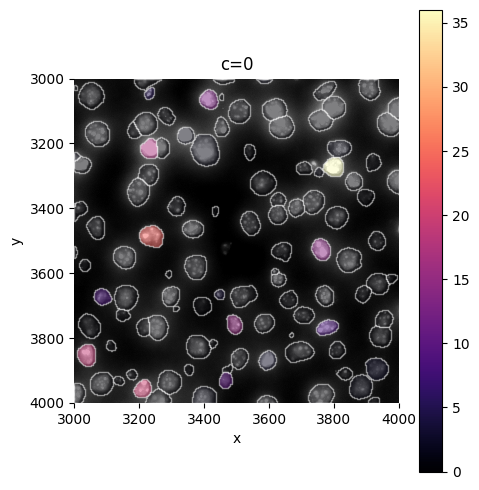

In [20]:
harpy.pl.plot_shapes(
    sdata,
    img_layer="raw_image",
    table_layer="table_transcriptomics",
    shapes_layer="segmentation_mask_boundaries",
    column="Stab2",
    crd=[3000, 4000, 3000, 4000],
    figsize=(5, 5),
)